# MNIST train

This is a part of some experiments for Knowledge Distillation.

- Train an MNIST model
- Train a smaller model (trainee) using Knowledge distillation
    - Find optimal parameter configs
- Compare with other training strategies
    - Train the smaller model from scratch
    - Train the smaller model from the trainee model's weights - does it diverge?
- Relevant metrics
    - Precision, recall, accuracy
    - Time the models

Other experiments to try:
- Other datasets?
- Mixture of experts -> one model somehow? (there'll be multiple soft targets OR mean them..)
- KD wrt different architectures:
    - ResNet -> ResNet?
    - ResNet -> simpler architecture
    - Simpler architecture to ResNet

### Other unrelated ideas

- Training strategies
    - Training techniques and tricks
        - Hard negative mining and how it helps
    - Curriculum learning
    - Annealing learning rates
    - Cyclic learning rates
    - Batch normalization

In [55]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

In [3]:
df_train_val = pd.read_csv('data/train.csv')

In [4]:
df_test = pd.read_csv('data/test.csv')

In [5]:
df_train_val.shape, df_test.shape

((42000, 785), (28000, 784))

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

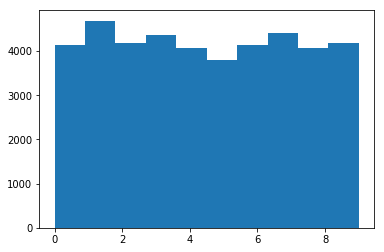

In [6]:
plt.hist(df_train_val.label)

### Split train into train-val

In [7]:
np.random.seed(1123)
df_train_val = df_train_val.sample(frac=1)

In [8]:
df_train_val.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
21290,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19992,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8221,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15284,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
val_frac = 0.1
n_train = math.ceil((1-val_frac) * df_train_val.shape[0])

df_train = df_train_val.iloc[:n_train]
df_val = df_train_val.iloc[n_train:]

assert df_train.shape[0] + df_val.shape[0] == df_train_val.shape[0]

In [10]:
df_train.shape

(37800, 785)

In [11]:
n_train = math.ceil((1-val_frac) * df_train_val.shape[0])

df_train = df_train_val.iloc[:n_train]
df_val = df_train_val.iloc[n_train:]

assert df_train.shape[0] + df_val.shape[0] == df_train_val.shape[0]

In [12]:
df_val.shape

(4200, 785)

### Create dataloaders

In [13]:
from typing import Tuple

In [14]:
from torch.utils.data import dataloader

In [15]:
import warnings

In [16]:
def get_dataset(df) -> Tuple[np.array, np.array]:
    if 'label' not in df:
        warnings.warn('This dataframe does not have labels! Using default label = -100')
        df = df.copy()
        df['label'] = -100
    
    # Extract numpy arrays
    labels = df['label'].values
    images = df.drop('label', axis=1).values
    assert len(labels) == len(images)
    
    # Reshape the images to make 28*28
    images = images.reshape(-1, 1, 28, 28)
    
    # Pad to 32*32
    images = np.pad(images, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)

    # Convert to pytorch Tensors
    images = torch.FloatTensor(images.astype(np.float32))
    labels = torch.LongTensor(labels.astype(np.int))
    
    # Create a dataset object
    dataset = torch.utils.data.TensorDataset(images, labels)
    assert len(dataset) == len(df)
    return dataset

In [17]:
%%time
dataset_train = get_dataset(df_train)
dataset_val = get_dataset(df_val)

CPU times: user 4.64 s, sys: 1.62 s, total: 6.26 s
Wall time: 1.66 s


In [18]:
print(len(dataset_train))
print(len(dataset_val))

37800
4200


In [19]:
batch_size = 8

In [20]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# Check sizes
for ix, _ in enumerate(dataloader_val):
    pass
assert (ix+1) * batch_size == len(dataset_val)

for ix, _ in enumerate(dataloader_train):
    pass
assert (ix+1) * batch_size == len(dataset_train)

### Test dataset

In [21]:
dataset_test = get_dataset(df_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

/home/anuj/miniconda3/envs/ocr/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This dataframe does not have labels! Using default label = -100
  This is separate from the ipykernel package so we can avoid doing imports until


### Visualize a few images

In [22]:
def visualize_batch(batch):
    images, labels = batch
    
    plt.figure(figsize=(20, 10))

    for ix in range(batch_size):
        plt.subplot(1, batch_size, ix+1)
        plt.imshow(images[ix].squeeze(), cmap='gray')
        plt.title(labels[ix].data.numpy())

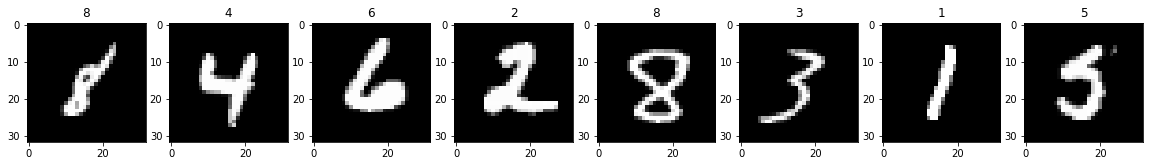

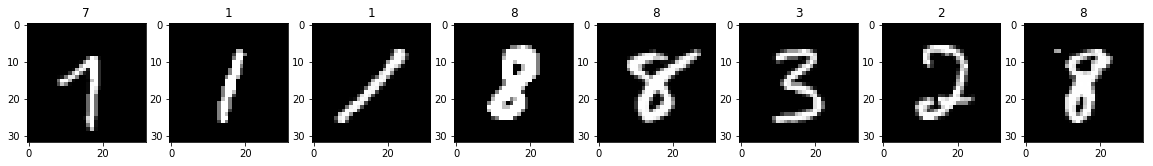

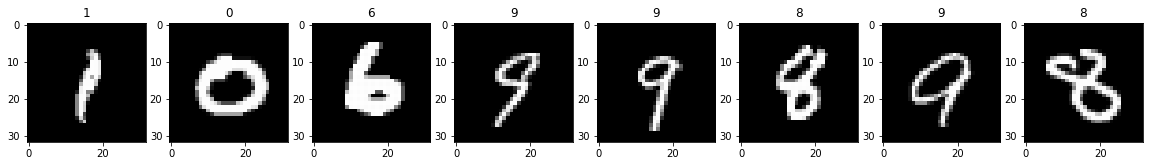

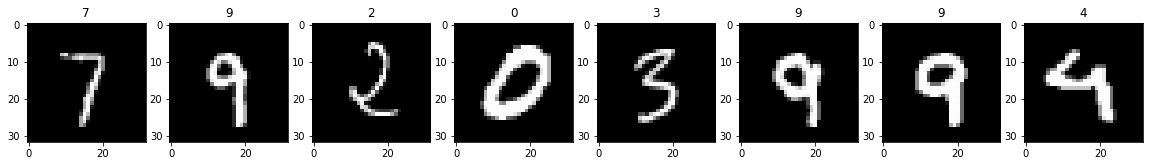

In [23]:
for ix, next_batch in enumerate(dataloader_train):
    if ix >= 4:
        break
    visualize_batch(next_batch)

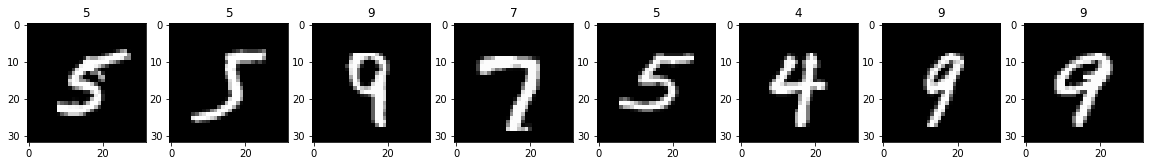

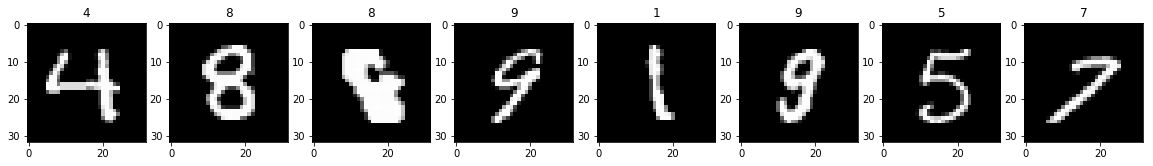

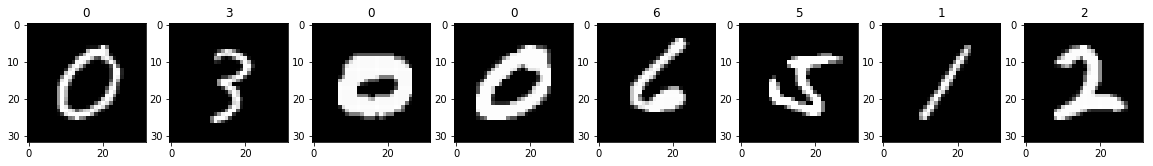

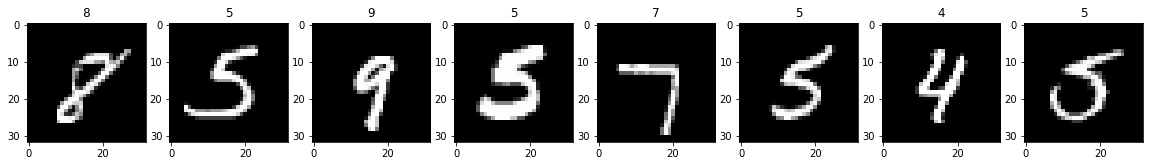

In [24]:
for ix, next_batch in enumerate(dataloader_val):
    if ix >= 4:
        break
    visualize_batch(next_batch)

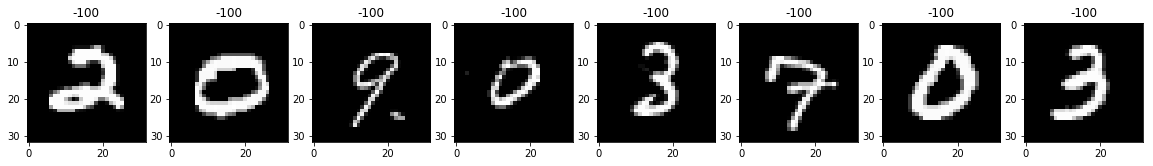

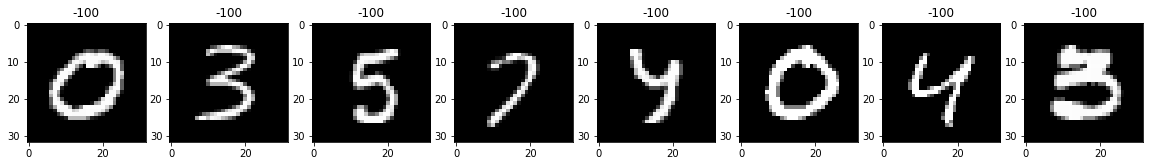

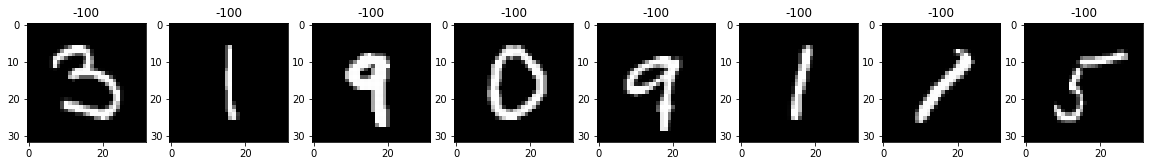

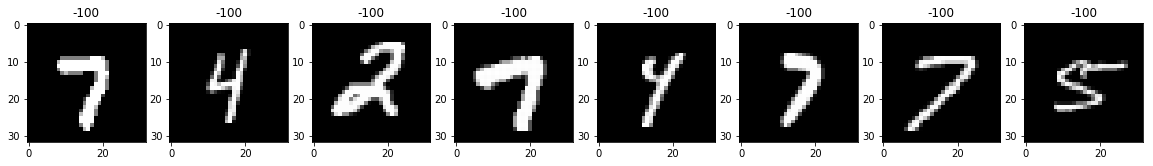

In [25]:
for ix, next_batch in enumerate(dataloader_test):
    if ix >= 4:
        break
    visualize_batch(next_batch)

### Get the relative label weights

In [26]:
loss_weights = np.bincount(df_train_val['label'])

In [27]:
loss_weights = 1. / loss_weights
loss_weights = loss_weights / loss_weights.sum()

Text(0,0.5,'Loss weight')

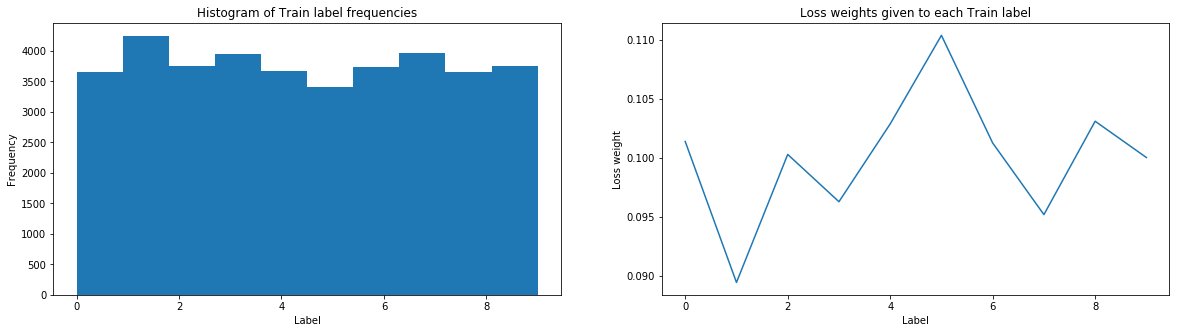

In [28]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(df_train['label'])
plt.title('Histogram of Train label frequencies')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(loss_weights)
plt.title('Loss weights given to each Train label')
plt.xlabel('Label')
plt.ylabel('Loss weight')

In [29]:
del df_train, df_val, df_train_val

## Model

In [30]:
import os
import pathlib
import tensorboardX

In [31]:
len(dataset_val)

4200

In [50]:
def forward_once(model, batch, loss=None):
    images, labels = batch
    images = images.cuda()
    labels = labels.cuda()
    
    preds = model(images)
    error = None
    if loss is not None:
        error = loss(preds, labels)
    return preds, error


def predict(model, dataloader, first_n=-1):
    list_all_preds = []
    for iteration, next_batch in enumerate(dataloader):
        preds, _ = forward_once(model, next_batch)
        preds = torch.argmax(preds, dim=1).data.cpu().numpy()
        list_all_preds += list(preds)

        if first_n > 0 and iteration + 1 >= first_n:
            break

    return np.array(list_all_preds)
        

def validate_model(model, dataloader, loss, n_iters=10, plot=True):
    assert n_iters > 0
    model.train(False)

    total_acc = 0
    total_error = 0
    for iteration, next_batch in enumerate(dataloader):
        preds, error = forward_once(model, next_batch, loss)
        preds = torch.argmax(preds, dim=1).data.cpu().numpy()
        acc = np.mean(preds == next_batch[1].numpy())
        
        total_error += error.data.cpu().numpy()
        total_acc += acc

        if iteration + 1 >= n_iters:
            break

    mean_acc = total_acc / (iteration+1)
    mean_error = total_error / (iteration+1)

    if plot:
        visualize_batch(next_batch)
        print('Preds:', preds)
        plt.show()

    model.train(True)
    
    return mean_error, mean_acc


def train(model, n_epochs=100, val_every=1000, log_every=100):
    """
    NOTE: DEPENDS ON MANY GLOBAL VARIABLES!
    """
    model.train(True)
    epochs = np.arange(n_epochs)

    total_iters = 0
    for epoch in epochs:
        for iteration, next_batch in enumerate(dataloader_train):
            total_iters += 1
            optimizer.zero_grad()
            preds, error = forward_once(model, next_batch, loss)
            error.backward()
            optimizer.step()

            # calculate acc
            preds = torch.argmax(preds, dim=1).data.cpu().numpy()
            acc_train = np.mean(preds == next_batch[1].numpy())

            if iteration % log_every == 0:
                writer.add_scalar('train.loss', error.data.cpu().numpy(), total_iters)
                writer.add_scalar('train.acc', acc_train, total_iters)

            if iteration % val_every == 0:
                err_val, acc_val = validate_model(model, dataloader_val, loss)

                print('Epoch: {}, Iteration: {}'.format(epoch, total_iters))
                print('Loss: {:.4f}, Accuracy: {:.2f}%'.format(err_val, acc_val*100))
                writer.add_scalar('val.loss', err_val, total_iters)
                writer.add_scalar('val.acc', acc_val, total_iters)

        # Save every epoch
        torch.save(model.state_dict(), path_to_weights / '{}.pt'.format(epoch))

### Create a simple model

In [33]:
class Net(nn.Module):
    @staticmethod
    def _make_encoder(n_in, n_out):
        return nn.Sequential(
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(num_features=n_out),
        )

    def __init__(self,) -> None:
        super().__init__()
        self.low_feat = self._make_encoder(1, 8)
        
        self.encoders = nn.Sequential(
            self._make_encoder(8, 16),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(16, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        
        self.linears = nn.Sequential(
            nn.Linear(512, 512),
            nn.Linear(512, 512),
        )
        
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        feats = self.low_feat(x)
        encoded = self.encoders(feats).view(-1, 512)
        preds = self.linears(encoded)
        preds = self.classifier(preds)
        return F.log_softmax(preds, dim=1)

In [34]:
def get_model_and_params(model_cls, gpu=None):
    # Test run!
    model = model_cls()

    img = torch.from_numpy(np.random.rand(1, 1, 32, 32).astype(np.float32))
    assert model(img).shape[1] == 10 and model(img).shape[0] == 1

    count = 0
    params = []
    for param in model.parameters():
        if param.requires_grad:
            count += np.prod(param.shape)
            params.append(param)

    print('{:,} trainable paramaters!'.format(count))
    if gpu is not None:
        model = model.cuda(device=gpu)

    return model, params

### Train

In [35]:
model, params = get_model_and_params(Net, gpu=0)

628,682 trainable paramaters!


In [36]:
loss_weights = torch.FloatTensor(loss_weights)

loss = nn.NLLLoss(weight=loss_weights).cuda()
optimizer = optim.SGD(params, lr=1e-3)

In [37]:
# Weights and logging directories
model_str = 'MNIST-big-1.09'

path_to_weights = pathlib.Path('/opt/anuj/weights') / model_str
path_to_log_s = '../tensorboard_logs/{}'.format(model_str)

# To prevent over-writing!
os.makedirs(str(path_to_weights), exist_ok=True)
writer = tensorboardX.SummaryWriter(path_to_log_s)

In [ ]:
train(model)

## Test

In [38]:
model.load_state_dict(torch.load('/opt/anuj/weights/MNIST-big-1.09/18.pt'))

Preds: [3 2 3 5 4 3 2 9]


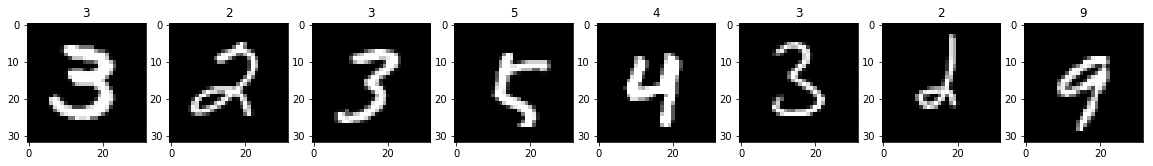

(0.0383974468514501, 0.991)

In [46]:
validate_model(model, dataloader_val, loss, n_iters=500)

In [52]:
%%time
test_labels = predict(model, dataloader_test, first_n=-1)

CPU times: user 2.98 s, sys: 45.4 ms, total: 3.03 s
Wall time: 3.02 s


In [53]:
len(test_labels)

28000

In [56]:
df_test['pred_labels'] = test_labels

In [54]:
test_labels[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

In [64]:
df_test['ImageId'] = df_test.index + 1

In [66]:
df_test[['ImageId', 'pred_labels']].rename({'pred_labels': 'Label'}, axis=1)\
                                   .to_csv('test_pred.csvd.csv', index=False)